# Vertex AI
Save the experiments in "vertex experiments" and compare the results of differents experiments

Introductory level

### 0. Packages

In [1]:
# ml packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


# evaluate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# vertex gcp
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

### 1. Load data, EDA, train model
In this part we run all the clasic codes to train a machine learning model and save a certain number of variables with important values that we want to save to registry our experiment

#### 1.1 Load Data

In [2]:
# load data
data_X, data_y = fetch_california_housing(return_X_y=True, as_frame=True)

In [3]:
data_X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
data_y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

#### 1.2 EDA

In [5]:
# EDA
data_X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


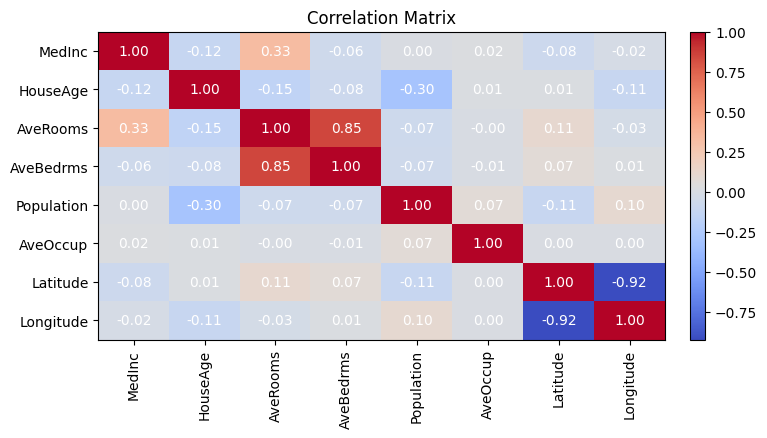

In [6]:
# correlations between features
corr = data_X.corr()

# Crear un mapa de calor con Matplotlib
plt.figure(figsize=(8, 4))
heatmap = plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')

# Mostrar los valores en cada celda
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='w')

# Añadir barra de color
plt.colorbar(heatmap, fraction=0.046, pad=0.04)

# Añadir etiquetas
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)

# Añadir título
plt.title('Correlation Matrix')

# save
name_correleation_matrix = 'correlation_matrix.png'
plt.savefig(name_correleation_matrix)

# Mostrar el gráfico
plt.show()

In [7]:
data_X.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000


#### 1.3 split data

In [8]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.25, random_state = 0)

In [9]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1.4 Values of target

In [10]:
# statistics target
y_train_mean = round(y_train.mean(), 2)
y_train_std = round(y_train.std(), 2)
y_test_mean = round(y_test.mean(), 2)
y_test_std = round(y_test.std(), 2)

print('statistics target')
print(f'--train-- mean = {y_train_mean}, std = {y_train_std}')
print(f'--test-- mean = {y_test_mean}, std = {y_test_std}')

statistics target
--train-- mean = 2.07, std = 1.16
--test-- mean = 2.05, std = 1.15


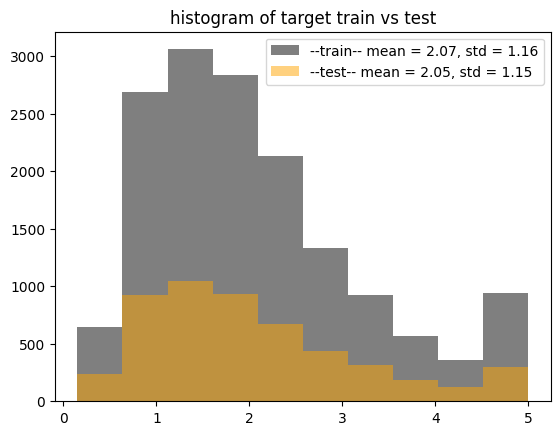

In [11]:
# histogram target
plt.hist(y_train, 
         color = 'black', 
         alpha = 0.5,
        label = f'--train-- mean = {y_train_mean}, std = {y_train_std}'
        )

plt.hist(y_test, 
         color = 'orange', 
         alpha = 0.5,
        label = f'--test-- mean = {y_test_mean}, std = {y_test_std}'
        )

plt.title('histogram of target train vs test')
plt.legend()

# save
name_histograms_target = 'histograms_target_train_test.png'
plt.savefig(name_histograms_target)

# show
plt.show()

### 2. Train models, evaluate it and save results
Train all the models with the same dataset and evaluate with the same dataset

Models trained (each model trained is saved in a different run)
- linear regression
- decision tree
- random forest (small)
- random forest (medium)
- random forest (default)
- nn mlp (using sklearn)

### 2.0 Auxiliar functions

#### 2.1 Auxiliar functions train/evaluate models

In [12]:
def evaluate_model(y_true, y_predicted):
    """
    Given "y_true" and "y_predicted" calculate metrics of performance (r2, rmse, mae)
    """
    r2_metric = r2_score(y_true, y_predicted)

    rmse_metric = mean_squared_error(y_true, y_predicted, squared = False)

    mae_metric = mean_absolute_error(y_true, y_predicted)

    print("r2: ", r2_metric)
    print("rmse: ", rmse_metric)
    print("mae_metric: ", mae_metric)
    return r2_metric, rmse_metric, mae_metric

#### 2.2 Auxiliar functions registry runs in vertex Experiments

In [13]:
def create_instance_tensorboard(experiment_name, experiment_description, project_gcp, location_gcp):
    """
    Create a vertex tensorboard instance. The instance of tensorboard is created with the idea to have the same name of the experiment of vertex ai
    that will use this instance of vertex tensorboard.

    Obs: This code create always a tensorboard instance, with the same name (display_name) but different ID, so it is necessary RUN ONCE
    
    Args
        experiment_name (string)
        experiment_description (string)
        project_gcp (string)
        location_gcp (string)

    Return
        id_experiment_tensorboard (vertex ai tensorboard object)
    """
    id_tensorboard_vertex = vertex_ai.Tensorboard.create(display_name = f'tensorboard-{experiment_name}',
                                                          description = f'tensorboard-{experiment_description}',
                                                          project = project_gcp,
                                                          location = location_gcp
                                                         )
    return id_tensorboard_vertex

In [14]:
def get_tensorboard_instance_or_create(experiment_name, experiment_description, project_gcp, location_gcp):
    """
    Search if exist a tensorboard instance and get it. If the instance doesn't exist, create it.
    The instance of tensorboard has its name with the idea to have the same name of the experiment of vertex ai that will use this instance
    of vertex.

    Args
        experiment_name (string)
        experiment_description (string)
        project_gcp (string)
        location_gcp (string)

    Return
        id_experiment_tensorboard (vertex ai tensorboard object)
    """
    
    ''' search tensorboard instance. if the list is empty the tensorboard instance doesn't exist and it will created '''
    # GET tensorboard instance created FILTERING by display name. return a list of the instance doesn't exist return a empty list
    list_tensorboard_vertex = vertex_ai.Tensorboard.list(
        filter = f'display_name="tensorboard-{experiment_name}"',
        project = project_gcp,
        location = location_gcp
    )

    # if vertex tensorboard instance doesn't exist, create it
    if len(list_tensorboard_vertex) == 0:
        print('--- creating vertex tensorboard instance ---')
        id_tensorboard_vertex = vertex_ai.Tensorboard.create(display_name = f'tensorboard-{experiment_name}',
                                                                 description = f'tensorboard-{experiment_description}',
                                                                 project = project_gcp,
                                                                 location = location_gcp
                                                                ) # return tensorboard instance created
    else:
        print('--- tensorboard instance already exists ---')
        id_tensorboard_vertex = list_tensorboard_vertex[0] # tensorboard instance exists, return it
    
    return id_tensorboard_vertex

In [15]:
def save_local_to_gcs(uri_gcs, uri_local):
    """
    AUXILIAR. Save a locally file onto GCS.
    Args:
        uri_gcs (string): path in gcs where the local file will be saved
        uri_local (strring). path in local where the local file was saved

    Return
        nothing
    """

    blob = storage.blob.Blob.from_string(uri_gcs, client=storage.Client())
    blob.upload_from_filename(uri_local)

In [16]:
def save_artifacts_experiments_vertex(path_artifact_locally, type_artifact, bucket_gcs, experiment_name, run_name):
    """
    Save an artifact in experiments in vertex. This functions works for an individual artifact. The run of the experiment needs to be created
    The input is a file saved locally and the output is the file registered as a artifact of a run of a vertex experiment
    
    There following steps are necesarys to save the artifact
    - save artifact locally
    - save artifact in GCS
    - link the artifact in GCS with vertex metadata
    - link vertex metadata with an artifact saved in a run (experiment vertex)
    - delete the file locally
    """

    # 1. save artifact locally (done -input function)


    # 2. save artifact in GCS
    path_artifact_gcs = f'gs://{bucket_gcs}/{experiment_name}/{run_name}/{path_artifact_locally}'
    save_local_to_gcs(uri_gcs = path_artifact_gcs, 
                      uri_local = path_artifact_locally)

    
    # 3. link the artifact in GCS with vertex metadata
    path_artifact_locally_corrected = path_artifact_locally.replace('_', '-').replace('.', '-') # in the name only accepted "-"
    
    artifact_metadata = vertex_ai.Artifact.create(
        schema_title = "system.Artifact", 
        uri = path_artifact_gcs, # 
        display_name = f"artifact-{path_artifact_locally}", # nombre con el que se muestra en el menu "metadata"
        description = f"description-{path_artifact_locally}",
        resource_id = f"{path_artifact_locally_corrected}-{EXPERIMENT_NAME}-{RUN_NAME}"  # nombre con el que se muestra en el menu "artifact del run del experimento" de vertex. No acepta espacios
        )


    # 4. link vertex metadata with an artifact saved in a run 
    executions = vertex_ai.start_execution(
        schema_title="system.ContainerExecution", 
        display_name='REGISTRO DE ARTIFACTS'
    )
    executions.assign_input_artifacts([artifact_metadata])

    
    # 5. delete the file local
    #os.remove(path_artifact_locally)

In [17]:
# create tensorboard instance. ONLY ONCE. THE FIRST TIME. 
#------> There is other code to search if a tensorboard instance exist and the create it
"""
experiment_tensorboard = create_instance_tensorboard(experiment_name = 'prueba_codes_final_v3',
                                                     experiment_description = 'prueba de códigos final, empaquetado en funciones',
                                                     project_gcp = PROJECT_GCP,
                                                     location_gcp = LOCATION_GCP
                                                    )
experiment_tensorboard
"""

"\nexperiment_tensorboard = create_instance_tensorboard(experiment_name = 'prueba_codes_final_v3',\n                                                     experiment_description = 'prueba de códigos final, empaquetado en funciones',\n                                                     project_gcp = PROJECT_GCP,\n                                                     location_gcp = LOCATION_GCP\n                                                    )\nexperiment_tensorboard\n"

#### 2.0 Parámetros

In [18]:
# PARAMETERS GCP

# get environment variables from .env - only necesary using a jupyter notebook
load_dotenv(find_dotenv())

# read env variables
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")
LOCATION_GCP = os.environ.get("LOCATION_GCP", "")
BUCKET_NAME = os.environ.get("BUCKET_NAME", "")



# PARAMETERS TO CREATE AN EXPERIMENT IN VERTEX AI
# obs: In names only are accepted '[a-z0-9][a-z0-9-]{0,127}'
EXPERIMENT_NAME = 'predictions-housing-price'
EXPERIMENT_DESCRIPTION = 'Test saving results of diferents runs in vertex experiments'

#### 2.1 Set experiment vertex

In [19]:
# search tensorboard instance, if it doesn't exist -> created it
id_tensorboard_vertex = get_tensorboard_instance_or_create(experiment_name = EXPERIMENT_NAME,
                                                           experiment_description = EXPERIMENT_DESCRIPTION,
                                                           project_gcp = PROJECT_GCP,
                                                           location_gcp = LOCATION_GCP
                                                          )

# set experiment (or created if it doesn't exist - automatically)
print('\n--- setting experiment vertex ai ---')
vertex_ai.init(
    experiment = EXPERIMENT_NAME,
    experiment_description = EXPERIMENT_DESCRIPTION,
    experiment_tensorboard = id_tensorboard_vertex,
    project = PROJECT_GCP,
    location = LOCATION_GCP,
    )

--- creating vertex tensorboard instance ---
Creating Tensorboard
Create Tensorboard backing LRO: projects/724348686027/locations/us-east1/tensorboards/6222426572654116864/operations/6150774973284745216
Tensorboard created. Resource name: projects/724348686027/locations/us-east1/tensorboards/6222426572654116864
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/724348686027/locations/us-east1/tensorboards/6222426572654116864')

--- setting experiment vertex ai ---


#### 2.1 linear regression (lr)

In [20]:
# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# get predictions
y_test_predicted = lr.predict(X_test)

# evaluate
r2_lr, rmse_lr, mae_lr = evaluate_model(y_test, y_test_predicted)

r2:  0.5911695436410489
rmse:  0.7351277481981672
mae_metric:  0.5368950735045218


In [21]:
""" registry run in experiment """
RUN_NAME = "run-lr"

# create a run
vertex_ai.start_run(RUN_NAME)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_lr,
    'rmse': rmse_lr,
    'mae': mae_lr
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)

# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(lr, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-lr to Experiment: predictions-housing-price


# TODO: PASS ARGS OF TRAINING AS **ARGS AND THIS SAME VALUES SEE IF I CAN SAVE IN VERTEX

#### 2.2 decision tree (tree)

In [22]:
### parameters
max_depth_tree = 15
min_samples_split_tree = 10 
min_samples_leaf_tree = 10


# train model
tree = DecisionTreeRegressor(max_depth = max_depth_tree,
                             min_samples_split = min_samples_split_tree,
                             min_samples_leaf = min_samples_leaf_tree,
                             random_state=42
                            )
tree.fit(X_train, y_train)

# get predictions
y_test_predicted = tree.predict(X_test)


# evaluate
r2_tree, rmse_tree, mae_tree = evaluate_model(y_test, y_test_predicted)

r2:  0.7040123226465862
rmse:  0.62550100313855
mae_metric:  0.41169095098400965


In [23]:
""" registry run in experiment """
RUN_NAME = "run-tree"

# create a run
vertex_ai.start_run(RUN_NAME)

# define params to save. In a dicctionary
params_to_save = {
    'max_depth': max_depth_tree,
    'min_samples_split': min_samples_split_tree,
    'min_samples_leaf': min_samples_leaf_tree
}

# save parameters
vertex_ai.log_params(params_to_save)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_tree,
    'rmse': rmse_tree,
    'mae': mae_tree
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)


# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(tree, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-tree to Experiment: predictions-housing-price


#### 2.3 random forest (small) (rf_small)

In [24]:
### parameters
n_estimators_rf_small = 5
max_depth_rf_small = 50
min_samples_split_rf_small = 10 
min_samples_leaf_rf_small = 10


# train model
rf_small = RandomForestRegressor(n_estimators = n_estimators_rf_small,
                                   max_depth = max_depth_rf_small,
                                   min_samples_split = min_samples_split_rf_small,
                                   min_samples_leaf = min_samples_leaf_rf_small,
                                   random_state=42
                                  )
rf_small.fit(X_train, y_train)


# get predictions
y_test_predicted = rf_small.predict(X_test)


# evaluate
r2_rf_small, rmse_rf_small, mae_rf_small = evaluate_model(y_test, y_test_predicted)

r2:  0.7542392782262851
rmse:  0.5699640083713956
mae_metric:  0.3806951755843425


In [25]:
""" registry run in experiment """
RUN_NAME = "run-rf-small"

# create a run
vertex_ai.start_run(RUN_NAME)

# define params to save. In a dicctionary
params_to_save = {
    'n_estimators': n_estimators_rf_small,
    'max_depth': max_depth_rf_small,
    'min_samples_split': min_samples_split_rf_small,
    'min_samples_leaf': min_samples_leaf_rf_small
}

# save parameters
vertex_ai.log_params(params_to_save)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_rf_small,
    'rmse': rmse_rf_small,
    'mae': mae_rf_small
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)


# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(rf_small, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-rf-small to Experiment: predictions-housing-price


#### 2.4 random forest (medium) (rf_medium)

In [26]:
### parameters
n_estimators_rf_medium = 30
max_depth_rf_medium = 50
min_samples_split_rf_medium = 10 
min_samples_leaf_rf_medium = 10


# train model
rf_medium = RandomForestRegressor(n_estimators = n_estimators_rf_medium,
                                   max_depth = max_depth_rf_medium,
                                   min_samples_split = min_samples_split_rf_medium,
                                   min_samples_leaf = min_samples_leaf_rf_medium,
                                   random_state=42
                                  )
rf_medium.fit(X_train, y_train)


# get predictions
y_test_predicted = rf_medium.predict(X_test)


# evaluate
r2_rf_medium, rmse_rf_medium, mae_rf_medium = evaluate_model(y_test, y_test_predicted)

r2:  0.776039754340429
rmse:  0.5440974151994461
mae_metric:  0.35777649970673464


In [27]:
""" registry run in experiment """
RUN_NAME = "run-rf-medium"

# create a run
vertex_ai.start_run(RUN_NAME)

# define params to save. In a dicctionary
params_to_save = {
    'n_estimators': n_estimators_rf_medium,
    'max_depth': max_depth_rf_medium,
    'min_samples_split': min_samples_split_rf_medium,
    'min_samples_leaf': min_samples_leaf_rf_medium
}

# save parameters
vertex_ai.log_params(params_to_save)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_rf_medium,
    'rmse': rmse_rf_medium,
    'mae': mae_rf_medium
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)


# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(rf_medium, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-rf-medium to Experiment: predictions-housing-price


#### 2.5 random forest (default) (rf_default)

In [28]:
### parameters
n_estimators_rf_default = 100
max_depth_rf_default = 50
min_samples_split_rf_default = 10 
min_samples_leaf_rf_default = 10


# train model
rf_default = RandomForestRegressor(n_estimators = n_estimators_rf_default,
                                   max_depth = max_depth_rf_default,
                                   min_samples_split = min_samples_split_rf_default,
                                   min_samples_leaf = min_samples_leaf_rf_default,
                                   random_state=42
                                  )
rf_default.fit(X_train, y_train)


# get predictions
y_test_predicted = rf_default.predict(X_test)


# evaluate
r2_rf_default, rmse_rf_default, mae_rf_default = evaluate_model(y_test, y_test_predicted)

r2:  0.7793211510637315
rmse:  0.5400967328372988
mae_metric:  0.3542753793581683


In [29]:
""" registry run in experiment """
RUN_NAME = "run-rf-default"

# create a run
vertex_ai.start_run(RUN_NAME)

# define params to save. In a dicctionary
params_to_save = {
    'n_estimators': n_estimators_rf_default,
    'max_depth': max_depth_rf_default,
    'min_samples_split': min_samples_split_rf_default,
    'min_samples_leaf': min_samples_leaf_rf_default
}

# save parameters
vertex_ai.log_params(params_to_save)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_rf_default,
    'rmse': rmse_rf_default,
    'mae': mae_rf_default
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)


# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(rf_default, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )


### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-rf-default to Experiment: predictions-housing-price


#### 2.6 NN MLP (mlp-sk)

In [30]:
### parameters
hidden_layer_sizes_nn_mlp = [200, 100, 50, 25]
activation_nn_mlp = 'relu'
learning_rate_init_nn_mlp = 0.001
max_iter_nn_mlp = 200
early_stopping_nn_mlp = True
validation_fraction_nn_mlp = 0.1

# train model
nn_mlp = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes_nn_mlp,
                      activation = activation_nn_mlp,
                      learning_rate_init = learning_rate_init_nn_mlp,
                      max_iter = max_iter_nn_mlp,
                      early_stopping = early_stopping_nn_mlp,
                      validation_fraction = validation_fraction_nn_mlp,
                      random_state = 42
                     )
nn_mlp.fit(X_train, y_train)


# get predictions
y_test_predicted = nn_mlp.predict(X_test)


# evaluate
r2_nn_mlp, rmse_nn_mlp, mae_nn_mlp = evaluate_model(y_test, y_test_predicted)

r2:  0.7912591446093785
rmse:  0.5252849095910503
mae_metric:  0.35309668073260075


In [31]:
""" registry run in experiment """
RUN_NAME = "run-mlp-sk"

# create a run
vertex_ai.start_run(RUN_NAME)

# define params to save. In a dicctionary
params_to_save = {
    'hidden_layer_sizes_nn_mlp': '[200, 100, 50, 25]',  # only accepted float, integer or string
    'activation_nn_mlp': activation_nn_mlp,
    'learning_rate_init_nn_mlp': learning_rate_init_nn_mlp,
    'max_iter_nn_mlp': max_iter_nn_mlp,
    'early_stopping_nn_mlp': True,
    'validation_fraction_nn_mlp': validation_fraction_nn_mlp
}

# save parameters
vertex_ai.log_params(params_to_save)

# define metrics to save. In a dicctionary
metrics_to_save = {
    'r2': r2_nn_mlp,
    'rmse': rmse_nn_mlp,
    'mae': mae_nn_mlp
}

# save metrics
vertex_ai.log_metrics(metrics_to_save)



# save graphs
save_artifacts_experiments_vertex(path_artifact_locally = name_correleation_matrix, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

save_artifacts_experiments_vertex(path_artifact_locally = name_histograms_target, 
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )

# save model (but not registry)
model_name = 'model.pkl'
joblib.dump(nn_mlp, model_name) # save locally
save_artifacts_experiments_vertex(path_artifact_locally = model_name,
                                  type_artifact = 'artifact', 
                                  bucket_gcs = BUCKET_NAME, 
                                  experiment_name = EXPERIMENT_NAME, 
                                  run_name = RUN_NAME
                                 )



### terminar run
vertex_ai.end_run()

Associating projects/724348686027/locations/us-east1/metadataStores/default/contexts/predictions-housing-price-run-mlp-sk to Experiment: predictions-housing-price


In [32]:
stop

NameError: name 'stop' is not defined

#### 2.2 Extra - explore the efect of change "max_depth"
- Explore the efect changing the maximum depth of the tree

- Instead of doing a hp tunning, the idea is changing the values of "max_depth" and SEE IN VERTEX the efect of changing only one hiper-parameter

In [ ]:
#### SET EXPERIMENT

EXPERIMENT_NAME_DEPTH = 'usecase-housing-price-depth'
EXPERIMENT_DESCRIPTION_DEPTH = 'see the efect of changing the parameter max_depth in tree regressor'

# search tensorboard instance, if it doesn't exist -> created it
id_tensorboard_vertex = get_tensorboard_instance_or_create(experiment_name = EXPERIMENT_NAME_DEPTH,
                                                           experiment_description = EXPERIMENT_DESCRIPTION_DEPTH,
                                                           project_gcp = PROJECT_GCP,
                                                           location_gcp = LOCATION_GCP
                                                          )

# set experiment (or created if it doesn't exist - automatically)
print('\n--- setting experiment vertex ai ---')
vertex_ai.init(
    experiment = EXPERIMENT_NAME_DEPTH,
    experiment_description = EXPERIMENT_DESCRIPTION_DEPTH,
    experiment_tensorboard = id_tensorboard_vertex,
    project = PROJECT_GCP,
    location = LOCATION_GCP,
    )

In [ ]:
### parameters
max_depth_tree = [1,2,3,4,5,6,7,8,9,10]
min_samples_split_tree = 10
min_samples_leaf_tree = 20


# train model
for iter_max_depth in max_depth_tree:
    
    #### TRAIN AND EVALUATE
    tree = DecisionTreeRegressor(max_depth = iter_max_depth,
                                 min_samples_split = min_samples_split_tree,
                                 min_samples_leaf = min_samples_leaf_tree,
                                 random_state = 42
                                )
    tree.fit(X_train, y_train)
    y_test_predicted = tree.predict(X_test)
    r2_tree, rmse_tree, mae_tree = evaluate_model(y_test, y_test_predicted)


    #### SAVE VERTEX
    RUN_NAME = f"run-tree-depth-{iter_max_depth}"
    
    # create a run
    vertex_ai.start_run(RUN_NAME)
    
    # define params to save. In a dicctionary
    params_to_save = {
        'max-depth-tree': iter_max_depth,
        'split-tree': min_samples_split_tree,
        'leaf-tree': min_samples_leaf_tree
    }
    
    # save parameters
    vertex_ai.log_params(params_to_save)
    
    # define metrics to save. In a dicctionary
    metrics_to_save = {
        'r2': r2_tree,
        'rmse': rmse_tree,
        'mae': mae_tree
    }
    
    # save metrics
    vertex_ai.log_metrics(metrics_to_save)
    
    ### terminar run
    vertex_ai.end_run()

### 8. Delete files saved locally

In [33]:
### delete local files
os.remove(model_name)
os.remove(name_correleation_matrix)
os.remove(name_histograms_target)